In [1]:
# Python 3.8.10 64-bit
# Local Jupyter Notebook in VS Code

# Install requirements as listed in pyweka documentation.
# http://fracpete.github.io/python-weka-wrapper3/install.html#windows

# Oracle JDK required.
# https://www.oracle.com/java/technologies/downloads/#jdk17-windows

Install packages and libraries

In [2]:
#%pip install numpy-1.21.5+vanilla-cp38-cp38-win_amd64.whl
#%pip install javabridge-1.0.19-cp38-cp38-win_amd64.whl
#%pip install matplotlib-3.5.1-cp38-cp38-win_amd64.whl

In [3]:
#%pip install python-weka-wrapper3
#%pip install plotly

In [35]:
# Install python packages typically used with weka. Add / Remove items as needed.

import os
import glob
import tempfile
import itertools
import traceback
import numpy as np
import pandas as pd
import weka.core.jvm as jvm
import matplotlib.pyplot as plt
import weka.plot.classifiers as plot_cls
import plotly.graph_objects as go
import weka.plot.graph as graph
import weka.plot.graph as plot_graph
import weka.core.typeconv as typeconv
import weka.core.converters as converters
import plotly.graph_objects as go
import weka.plot.classifiers as plcls

from weka.filters import Filter
from weka.core.classes import from_commandline
from weka.core.classes import to_commandline
from weka.classifiers import Evaluation
from weka.core.classes import Random
from weka.filters import Filter
from weka.classifiers import Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random, from_commandline
from weka.classifiers import Classifier, SingleClassifierEnhancer, MultipleClassifiersCombiner, FilteredClassifier
from weka.classifiers import PredictionOutput, Kernel, KernelClassifier
from weka.experiments import SimpleCrossValidationExperiment, SimpleRandomSplitExperiment, Tester, ResultMatrix

Load data and create combined csv file

In [5]:

data_malware = pd.read_csv('datasetLegitimate33features.csv')
data_benign = pd.read_csv('datasetMalware33features.csv')
data_complete = pd.concat([data_malware, data_benign], ignore_index=True)

data_complete.to_csv("complete_MTAKDD19.csv", index=False)

Start Java VM for algorithm library and load data

In [7]:
import weka.core.jvm as jvm
jvm.start(packages=True,max_heap_size="16g")

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


In [8]:
# Load csv file

from weka.core.converters import Loader

csv_loader = Loader(classname="weka.core.converters.CSVLoader")
csv_data = csv_loader.load_file("complete_MTAKDD19.csv")
csv_data.class_is_last()

csv_remove = Filter(classname="weka.filters.unsupervised.attribute.NumericToNominal", options=["-R", "last"])
csv_remove.inputformat(csv_data)
dataset = csv_remove.filter(csv_data)


In [9]:
# create plot function

def plot_confusion_matrix(cm, title):

  plt.gcf().clear()
  fig = plt.figure(1)
  classes = ['Class A', 'Class B']
  plt.imshow(cm, interpolation='none', cmap=plt.cm.Blues, alpha=0.3)
  plt.title(title)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  fmt = 'd'
  thresh = 155
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="black")
  plt.imshow
  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted') 
  
  image = fig 
  display(image)
  plt.close(fig)

Decision Tree

In [10]:
# Build and run decision tree model

DT = Classifier(classname="weka.classifiers.trees.J48", options=["-C", "0.3"])
DT.build_classifier(dataset)

DT_evl = Evaluation(dataset)
DT_evl.crossvalidate_model(DT, dataset, 10, Random(1))

print(DT_evl.summary())
print(DT_evl.class_details())


Correctly Classified Instances       64549               99.9923 %
Incorrectly Classified Instances         5                0.0077 %
Kappa statistic                          0.9998
Mean absolute error                      0.0001
Root mean squared error                  0.0088
Relative absolute error                  0.0187 %
Root relative squared error              1.7638 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     0
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     1
Weighted Avg.    1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     



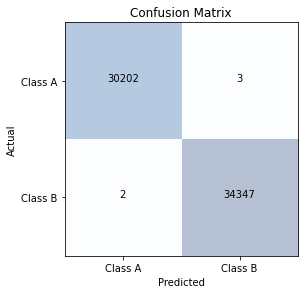

In [11]:
# Create array and print Confusion matrix graphic

evl = DT_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")


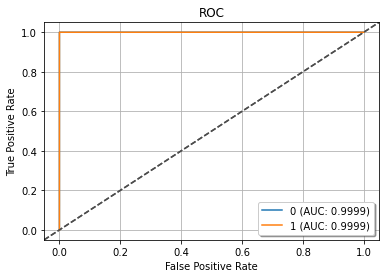

In [12]:
# Display ROC Curve

plcls.plot_roc(DT_evl, class_index=[0, 1], wait=True)

AdaBoost Decision Stump

In [13]:
# Build and run Decision Stump model with adaptive boosting ensemble algorithm 

B_DS_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.trees.DecisionStump'
B_DS_cls = from_commandline(B_DS_cmdline, classname="weka.classifiers.Classifier")
B_DS_cls.build_classifier(dataset)

B_DS_evl = Evaluation(dataset)
B_DS_evl.crossvalidate_model(B_DS_cls, dataset, 10, Random(1))

print(B_DS_evl.summary())
print(B_DS_evl.class_details())


Correctly Classified Instances       63053               97.6748 %
Incorrectly Classified Instances      1501                2.3252 %
Kappa statistic                          0.9532
Mean absolute error                      0.0367
Root mean squared error                  0.097 
Relative absolute error                  7.3735 %
Root relative squared error             19.4396 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.952    0.002    0.998      0.952    0.975      0.954    1.000     1.000     0
                 0.998    0.048    0.960      0.998    0.979      0.954    1.000     1.000     1
Weighted Avg.    0.977    0.026    0.978      0.977    0.977      0.954    1.000     1.000     



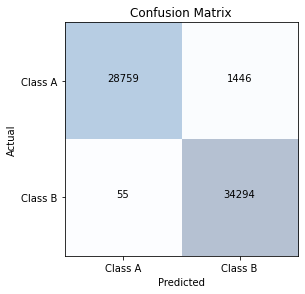

In [14]:
# Create array and print Confusion matrix graphic

evl = B_DS_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

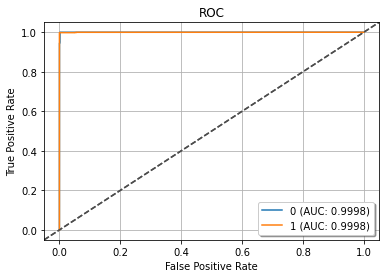

In [15]:
# Display ROC Curve

plcls.plot_roc(B_DS_evl, class_index=[0, 1], wait=True)

Naive Bayes

In [16]:
# Build and run Naive Bayes model

NB_cls = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
NB_cls.build_classifier(dataset)

NB_evl = Evaluation(dataset)
NB_evl.crossvalidate_model(NB_cls, dataset, 10, Random(1))

print(NB_evl.summary())
print(NB_evl.class_details())


Correctly Classified Instances       48841               75.6591 %
Incorrectly Classified Instances     15713               24.3409 %
Kappa statistic                          0.523 
Mean absolute error                      0.242 
Root mean squared error                  0.4779
Relative absolute error                 48.6048 %
Root relative squared error             95.7676 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.946    0.410    0.670      0.946    0.784      0.565    0.926     0.934     0
                 0.590    0.054    0.926      0.590    0.721      0.565    0.926     0.912     1
Weighted Avg.    0.757    0.221    0.806      0.757    0.750      0.565    0.926     0.922     



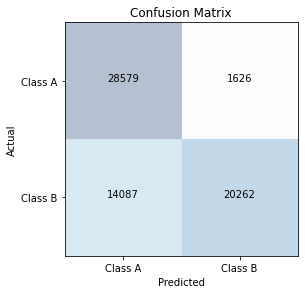

In [17]:
# Create array and print Confusion matrix graphic

evl = NB_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

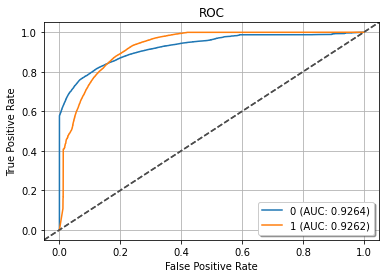

In [18]:
# Display ROC Curve

plcls.plot_roc(NB_evl, class_index=[0, 1], wait=True)

MLP Neural Network

In [19]:
# Build and run MLP model

MLP_cls = Classifier(classname="weka.classifiers.functions.MLPClassifier")
MLP_cls.build_classifier(dataset)

MLP_evl = Evaluation(dataset)
MLP_evl.crossvalidate_model(MLP_cls, dataset, 10, Random(1))

print(MLP_evl.summary())
print(MLP_evl.class_details())


Correctly Classified Instances       63714               98.6988 %
Incorrectly Classified Instances       840                1.3012 %
Kappa statistic                          0.9738
Mean absolute error                      0.0253
Root mean squared error                  0.1111
Relative absolute error                  5.0799 %
Root relative squared error             22.2723 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.980    0.007    0.992      0.980    0.986      0.974    0.992     0.993     0
                 0.993    0.020    0.983      0.993    0.988      0.974    0.992     0.984     1
Weighted Avg.    0.987    0.014    0.987      0.987    0.987      0.974    0.992     0.988     



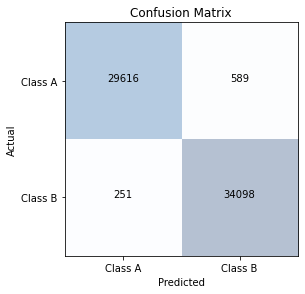

In [20]:
# Create array and print Confusion matrix graphic

evl = MLP_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

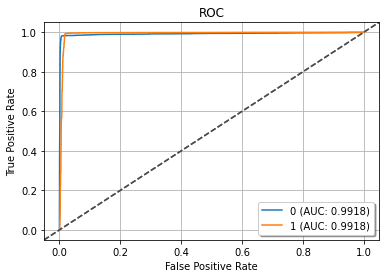

In [21]:
# Display ROC Curve

plcls.plot_roc(MLP_evl, class_index=[0, 1], wait=True)

Stochastic Gradient Descent

In [22]:
# Build and run SGD model

SGD = Classifier(classname="weka.classifiers.functions.SGD")
SGD.build_classifier(dataset)

SGD_evl = Evaluation(dataset)
SGD_evl.crossvalidate_model(SGD, dataset, 10, Random(1))

print(SGD_evl.summary())
print(SGD_evl.class_details())


Correctly Classified Instances       63176               97.8654 %
Incorrectly Classified Instances      1378                2.1346 %
Kappa statistic                          0.9571
Mean absolute error                      0.0213
Root mean squared error                  0.1461
Relative absolute error                  4.287  %
Root relative squared error             29.2813 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.967    0.011    0.988      0.967    0.977      0.957    0.978     0.970     0
                 0.989    0.033    0.971      0.989    0.980      0.957    0.978     0.966     1
Weighted Avg.    0.979    0.023    0.979      0.979    0.979      0.957    0.978     0.968     



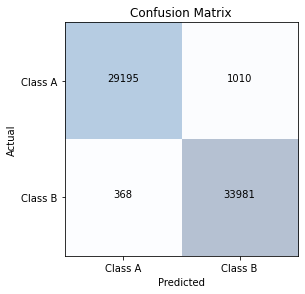

In [23]:
# Create array and print Confusion matrix graphic

evl = SGD_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

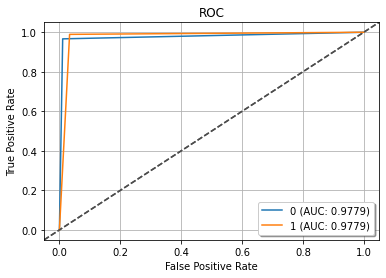

In [24]:
# Display ROC Curve

plcls.plot_roc(SGD_evl, class_index=[0, 1], wait=True)

KNN (K=1)

In [25]:
# Build and run KNN model

IBk = Classifier(classname="weka.classifiers.lazy.IBk", options=["-K","1"])
IBk.build_classifier(dataset)

IBk_evl = Evaluation(dataset)
IBk_evl.crossvalidate_model(IBk, dataset, 10, Random(1))

print(IBk_evl.summary())
print(IBk_evl.class_details())


Correctly Classified Instances       63910               99.0024 %
Incorrectly Classified Instances       644                0.9976 %
Kappa statistic                          0.98  
Mean absolute error                      0.01  
Root mean squared error                  0.0999
Relative absolute error                  2.0069 %
Root relative squared error             20.0171 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.991    0.011    0.988      0.991    0.989      0.980    0.990     0.984     0
                 0.989    0.009    0.992      0.989    0.991      0.980    0.990     0.988     1
Weighted Avg.    0.990    0.010    0.990      0.990    0.990      0.980    0.990     0.986     



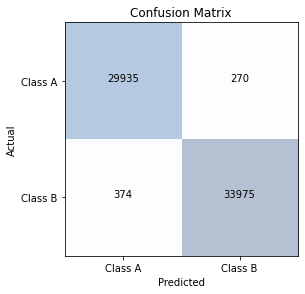

In [26]:
# Create array and print Confusion matrix graphic

evl = IBk_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

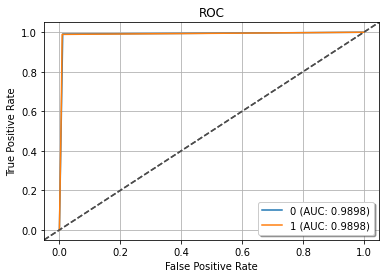

In [27]:
# Display ROC Curve

plcls.plot_roc(IBk_evl, class_index=[0, 1], wait=True)

Voting Feature Intervals

In [28]:
# Build and run voting feature interval model

VFI = Classifier(classname="weka.classifiers.misc.VFI")
VFI.build_classifier(dataset)

VFI_evl = Evaluation(dataset)
VFI_evl.crossvalidate_model(VFI, dataset, 10, Random(1))

print(VFI_evl.summary())
print(VFI_evl.class_details())


Correctly Classified Instances       53311               82.5836 %
Incorrectly Classified Instances     11243               17.4164 %
Kappa statistic                          0.6579
Mean absolute error                      0.27  
Root mean squared error                  0.327 
Relative absolute error                 54.2278 %
Root relative squared error             65.5406 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.327    0.729      1.000    0.843      0.700    0.946     0.940     0
                 0.673    0.000    0.999      0.673    0.804      0.700    0.946     0.958     1
Weighted Avg.    0.826    0.153    0.873      0.826    0.822      0.700    0.946     0.949     



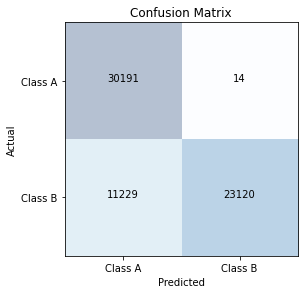

In [29]:
# Create array and print Confusion matrix graphic

evl = VFI_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

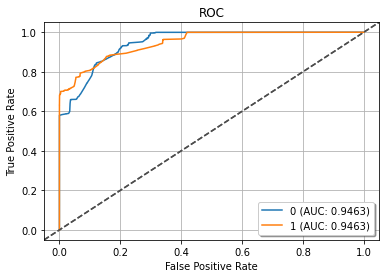

In [30]:
# Display ROC Curve

plcls.plot_roc(VFI_evl, class_index=[0, 1], wait=True)

Sequential Minimal Optimization SVM

In [31]:
# Build and run SMO SVM model

SMO = Classifier(classname="weka.classifiers.functions.SMO")
SMO.build_classifier(dataset)

SMO_evl = Evaluation(dataset)
SMO_evl.crossvalidate_model(SMO, dataset, 10, Random(1))

print(SMO_evl.summary())
print(SMO_evl.class_details())


Correctly Classified Instances       63117               97.774  %
Incorrectly Classified Instances      1437                2.226  %
Kappa statistic                          0.9552
Mean absolute error                      0.0223
Root mean squared error                  0.1492
Relative absolute error                  4.4705 %
Root relative squared error             29.9015 %
Total Number of Instances            64554     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.963    0.009    0.990      0.963    0.976      0.956    0.977     0.970     0
                 0.991    0.037    0.968      0.991    0.979      0.956    0.977     0.964     1
Weighted Avg.    0.978    0.024    0.978      0.978    0.978      0.956    0.977     0.967     



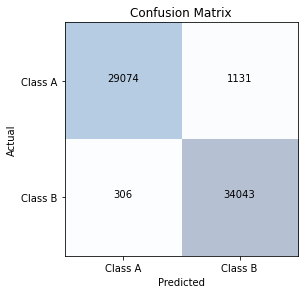

In [32]:
# Create array and print Confusion matrix graphic

evl = SMO_evl

DT_matrix = np.array([[int(evl.num_true_negatives(class_index=1)), int(evl.num_false_positives(class_index=1))],\
                      [int(evl.num_false_negatives(class_index=1)), int(evl.num_true_positives(class_index=1))]])
                      
plot_confusion_matrix(DT_matrix, "Confusion Matrix")

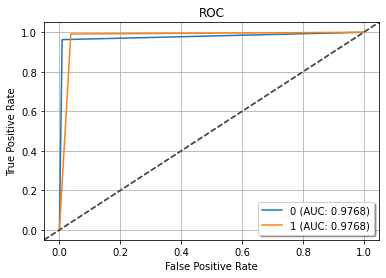

In [33]:
# Display ROC Curve

plcls.plot_roc(SMO_evl, class_index=[0, 1], wait=True)

Stop Java VM

In [34]:
# Stop JVM. May need to restart compute cluster or jupyter kernal if jvm restart is required.

jvm.stop()